# Part 1: Getting started

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/home/bcilab/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

2022-07-11 11:02:31.099274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 11:02:31.112076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATA_DIR = 'npy'
MODEL_DIR = 'model'

BOARD_NAME = 'ultra96v2'
FPGA_PART = 'xczu3eg-sbva484-1-i' 

CLOCK_PERIOD = 10

## Fetch the jet tagging dataset from Open ML

In [3]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [4]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [6]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [7]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [9]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

2022-07-11 11:03:15.235152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-11 11:03:15.235226: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-11 11:03:15.235281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bcilab-rrid411): /proc/driver/nvidia/version does not exist
2022-07-11 11:03:15.235983: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [10]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

/home/bcilab/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
486/487 [============================>.] - ETA: 0s - loss: 1.3292 - accuracy: 0.5160
***callbacks***
saving losses to model_1/losses.log

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_1/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 1.3290 - accuracy: 0.5161 - val_loss: 1.1252 - val_accuracy: 0.6363 - lr: 1.0000e-04
Epoch 2/30
482/487 [============================>.] - ETA: 0s - loss: 1.0555 - accuracy: 0.6666
***callbacks***
saving losses to model_1/losses.log

Epoch 00002: val_loss improved from 1.12515 to 1.00706, saving model to model_1/KERAS_check_best_model.h5

Epoch 00002: val_loss improved from 1.12515 to 1.00706, saving model to mode


Epoch 00012: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.8023 - accuracy: 0.7399 - val_loss: 0.8039 - val_accuracy: 0.7401 - lr: 1.0000e-04
Epoch 13/30
479/487 [============================>.] - ETA: 0s - loss: 0.7969 - accuracy: 0.7412
***callbacks***
saving losses to model_1/losses.log

Epoch 00013: val_loss improved from 0.80388 to 0.79879, saving model to model_1/KERAS_check_best_model.h5

Epoch 00013: val_loss improved from 0.80388 to 0.79879, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00013: saving model to model_1/KERAS_check_model_last.h5

Epoch 00013: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 2ms/step - loss: 0.7968 - accuracy: 0.7413 - val_loss: 0.7988 - val_accuracy: 0.7414 - lr: 1.0000e-04
Epoch 14/30
476/487 [============================>.] - ETA: 0s - loss: 0.7921 - a

Epoch 25/30
463/487 [===========================>..] - ETA: 0s - loss: 0.7637 - accuracy: 0.7504
***callbacks***
saving losses to model_1/losses.log

Epoch 00025: val_loss improved from 0.76961 to 0.76797, saving model to model_1/KERAS_check_best_model.h5

Epoch 00025: val_loss improved from 0.76961 to 0.76797, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 1s 3ms/step - loss: 0.7636 - accuracy: 0.7505 - val_loss: 0.7680 - val_accuracy: 0.7493 - lr: 1.0000e-04
Epoch 26/30
479/487 [============================>.] - ETA: 0s - loss: 0.7618 - accuracy: 0.7509
***callbacks***
saving losses to model_1/losses.log

Epoch 00026: val_loss improved from 0.76797 to 0.76638, saving model to model_1/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 0.76797 to 0.76638, saving mod

## Check performance
Check the accuracy and make a ROC curve

Accuracy: 0.7502530120481927


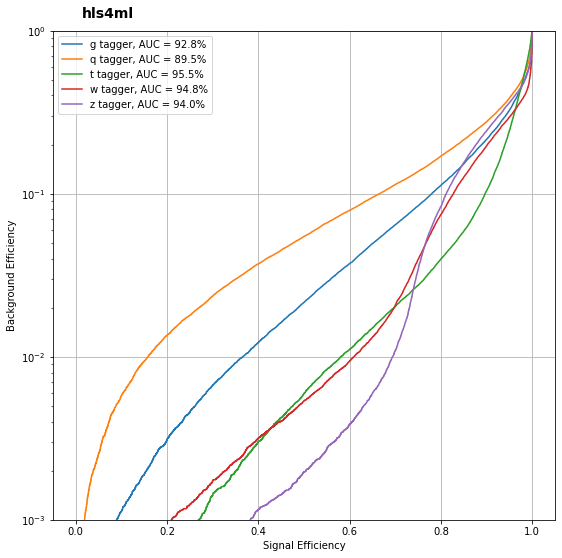

In [11]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_test)
np.save('y_qkeras.npy', y_keras)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

# Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

## Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [12]:
import hls4ml
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

hls_config['Model'] = {}
hls_config['Model']['ReuseFactor'] = 64
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['LayerName']['fc1']['ReuseFactor'] = 64
hls_config['LayerName']['fc2']['ReuseFactor'] = 64
hls_config['LayerName']['fc3']['ReuseFactor'] = 64
input_data = os.path.join(os.getcwd(), 'X_test.npy')
output_predictions = os.path.join(os.getcwd(), 'y_qkeras.npy')

hls_config['SkipOptimizers'] = ['relu_merge']

hls_model = hls4ml.converters.convert_from_keras_model(model=model,
                                     clock_period=CLOCK_PERIOD,
                                     backend='VivadoAccelerator',
                                     board=BOARD_NAME,
                                     part=FPGA_PART,
                                     io_type='io_stream',
                                     interface='axi_stream',
                                     driver='c',
                                     input_data_tb='X_test.npy',
                                     output_data_tb='y_qkeras.npy',
                                     hls_config=hls_config,
                                     output_dir='model_1/hls4ml_prj')

/home/bcilab/anaconda3/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Ac

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

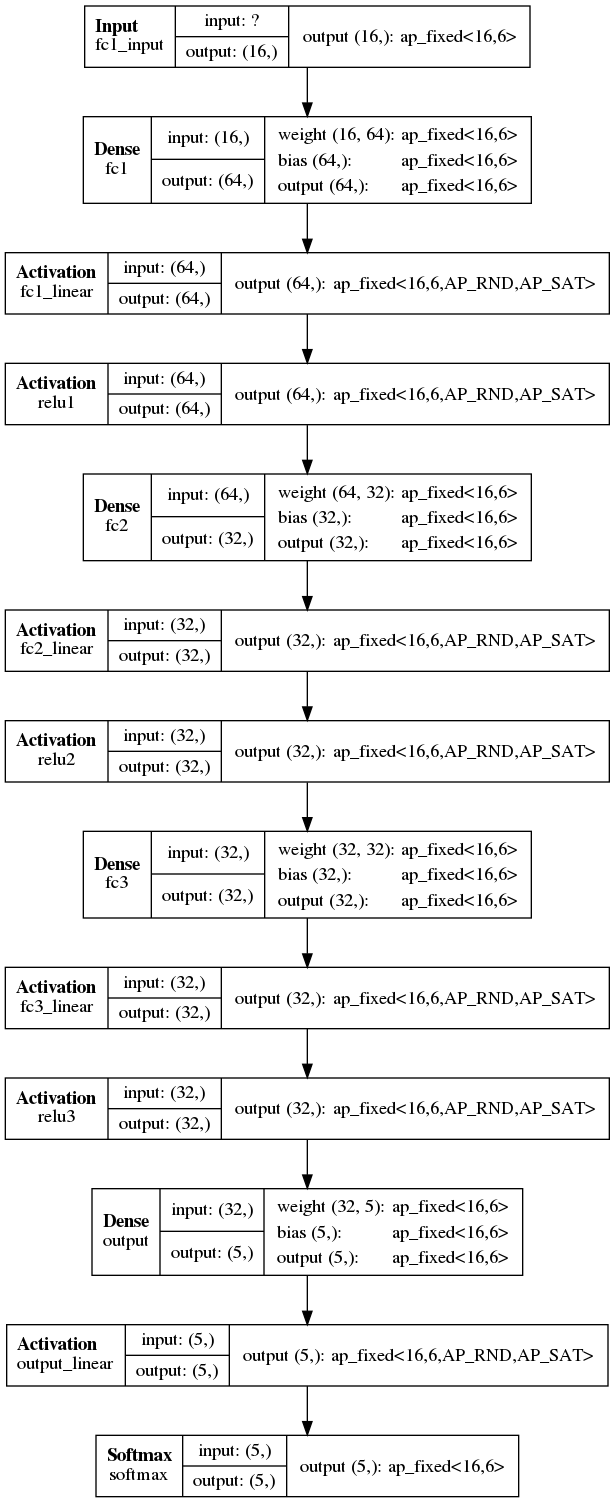

In [13]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [14]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7502530120481927
hls4ml Accuracy: 0.750343373493976


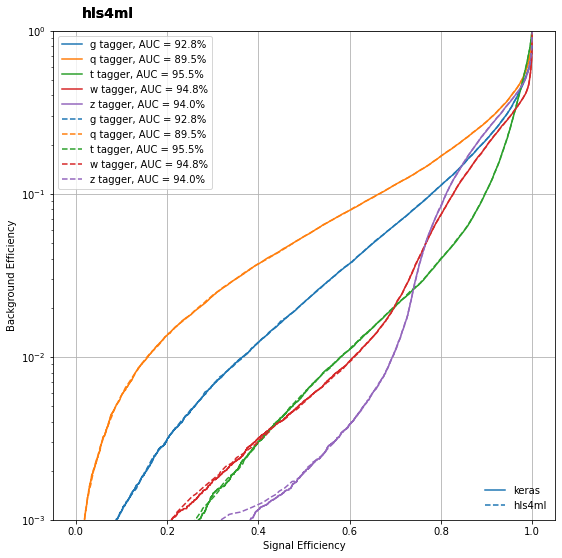

In [15]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [16]:
hls_model.build(csim=False, synth=True, export=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/bcilab/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/bcilab/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'bcilab' on host 'bcilab-rrid411' (Linux_x86_64 version 4.15.0-188-generic) on Mon Jul 11 11:05:15 IST 2022
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10]

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>::operator[].1' into 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>::operator=' (firmware/nnet_utils/nnet_types.h:34).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 5u>::operator[]' into 'nnet::softmax_latency<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 5u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, softmax_config13>' (firmware/nnet_utils/nnet_activation_stream.h:155).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 5u>::operator[]' into 'nnet::linear<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 5u>, linear_config12>' (firmware/nnet_utils/nnet_activation_stream.h:47).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_m

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_latency<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 5u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, softmax_config13>' (firmware/nnet_utils/nnet_activation_stream.h:32:59).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, relu_config4>' (firmware/nnet_utils/nnet_activation_stream.h:32:49).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, relu_config7>' (firmware/nnet_utils/nnet_activation_stream.h:32:49).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 

INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_types.h:32) in function 'nnet::dense<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'DataPack' (firmware/nnet_utils/nnet_dense_stream.h:46) in function 'nnet::dense<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'ResPack' (firmware/nnet_utils/nnet_dense_stream.h:60) in function 'nnet::dense<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_types.h:32) in function 'nnet::dense<nnet::array<ap_fixed<16, 6, (ap_q

INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.20' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data.V' (firmware/nnet_utils/nnet_dense_stream.h:35) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'res'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.22' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data.V' (firmware/nnet_utils/nnet_dense_stream.h:35) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'res'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.24' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.26' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b11.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:54) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b8.V'  in dimension 1 comple

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 13 process function(s): 
	 'myproject_Block__proc'
	 'nnet::dense<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, config2>'
	 'nnet::linear<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, linear_config3>'
	 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, relu_config4>'
	 'nnet::dense<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>'
	 'nnet::linear<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, linear_config6>'
	 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)0, (ap_

INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:151) in function 'dense_wrapper<ap_fixed,ap_fixed<16,6,5,3,0>,config8>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:64) in function 'dense_wrapper<ap_fixed,ap_fixed<16,6,5,3,0>,config5>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:151) in function 'dense_wrapper<ap_fixed,ap_fixed<16,6,5,3,0>,config2>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:64) in function 'dense_wrapper<ap_fixed,ap_fixed<16,6,5,3,0>,config11>'.
INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:01:06 ; elapsed = 00:01:17 . Memory (MB): peak = 1152.254 ; gain = 450.969 ; free physical = 211 ; free virtual = 13616
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject_axi' ...
INFO: [HLS 200-10] ----------------------------

INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,64u>,relu_config4>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.24 seconds; current allocated memory: 467.651 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.29 seconds; current allocated memory: 469.342 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_wrapper_ap_fixed_ap_fixed_16_6_5_3_0_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop

INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.48 seconds; current allocated memory: 485.405 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.49 seconds; current allocated memory: 487.813 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_array_array_ap_fixed_16_6_5_3_0_5u_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time:

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_16_6_5_3_0_64u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_16_6_5_3_0_64u_config2_s'.
INFO: [HLS 200-111]  Elapsed time: 0.88 seconds; current allocated memory: 538.706 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'linear_array_array_ap_fixed_64u_linear_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'linear_array_array_ap_fixed_64u_linear_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 0.4 seconds; current allocated memory: 547.194 MB.
INFO: [HLS 200-10] ------------------------------------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_32u_config5_U0' to 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_32u_confidEe' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_32u_config8_U0' to 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_32u_confieOg' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_5u_config11_U0' to 'start_for_dense_array_array_ap_fixed_16_6_5_3_0_5u_configfYi' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_softmax_array_array_ap_fixed_5u_softmax_config13_U0' to 'start_for_softmax_array_array_ap_fixed_5u_softmax_config1g8j' due to 

INFO: [HLS 200-111] Finished generating all RTL models Time (s): cpu = 00:01:44 ; elapsed = 00:02:00 . Memory (MB): peak = 1408.254 ; gain = 706.969 ; free physical = 178 ; free virtual = 13381
INFO: [VHDL 208-304] Generating VHDL RTL for myproject_axi.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject_axi.
***** C/RTL SYNTHESIS COMPLETED IN 0h1m52s *****
***** EXPORT IP *****
INFO: [IMPL 213-8] Exporting RTL as a Vivado IP.

****** Vivado v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source run_ippack.tcl -notrace
INFO: [IP_Flow 19-234] Refreshing IP repositories
INFO: [IP_Flow 19-1704] No user IP repositories specified
INFO: [IP_Flow 19-2313] Loaded Vivado IP repository '/home/bcilab/Xilinx/Vivado/2019.1/data/ip'.
create_ip: Time (s): cpu = 00:00:03 ; elapsed = 00:00:08 . Memory (MB): peak = 1438.250 ; gain = 73.887 ; free physical =

{'EstimatedClockPeriod': '8.716',
 'BestLatency': '75',
 'WorstLatency': '76',
 'IntervalMin': '66',
 'IntervalMax': '67',
 'BRAM_18K': '69',
 'DSP48E': '149',
 'FF': '14381',
 'LUT': '43785',
 'URAM': '0',
 'AvailableBRAM_18K': '432',
 'AvailableDSP48E': '360',
 'AvailableFF': '141120',
 'AvailableLUT': '70560',
 'AvailableURAM': '0'}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [17]:
hls4ml.writer.vivado_accelerator_writer.VivadoAcceleratorWriter.write_header_file(hls_model, X_test, y_test, y_keras, y_hls, 64, 'model_1/hls4ml_prj/sdk/common/data.h')

In [18]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Mon Jul 11 11:07:01 2022

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |  10.00|     8.716|        1.25|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   75|   76|   66|   67| dataflow |
    +-----+-----+-----+-----+--

In [19]:
hls4ml.templates.VivadoAcceleratorBackend.make_bitfile(hls_model)


****** Vivado v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source design.tcl
# set tcldir [file dirname [info script]]
# source [file join $tcldir project.tcl]
## variable myproject
## set myproject "myproject"
## set bit_width_hls_output 32
## set bit_width_hls_input 32
## set fifo_opt 0
## set eembc_power 0
# create_project project_1 ${myproject}_vivado_accelerator -part xczu9eg-ffvb1156-2-e -force
# set_property board_part avnet.com:ultra96v2:part0:1.2 [current_project]
INFO: [Project 1-152] Project part set to zynquplus (xczu3eg-sbva484-1-i)
# set_property  ip_repo_paths  ${myproject}_prj [current_project]
# update_ip_catalog
INFO: [IP_Flow 19-234] Refreshing IP repositories
INFO: [IP_Flow 19-1700] Loaded user IP repository '/home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_prj'.
INFO: [IP_Flow 19-2313] Loaded Vivado IP r

INFO: [Ipptcl 7-1463] No Compatible Board Interface found. Board Tab not created in customize GUI
Wrote  : </home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/design_1.bd> 
VHDL Output written to : /home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/synth/design_1.v
VHDL Output written to : /home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/sim/design_1.v
VHDL Output written to : /home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hdl/design_1_wrapper.v
make_wrapper: Time (s): cpu = 00:00:04 ; elapsed = 00:00:06 . Memory (MB): peak = 1744.273 ; gain = 173.781 ; free physical = 346 ; free virtual = 13530
# add_files -norecurse ./${myproject}_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hdl/design_1_


*** Running vivado
    with args -log design_1_wrapper.vdi -applog -m64 -product Vivado -messageDb vivado.pb -mode batch -source design_1_wrapper.tcl -notrace


****** Vivado v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source design_1_wrapper.tcl -notrace
INFO: [IP_Flow 19-234] Refreshing IP repositories
INFO: [IP_Flow 19-1700] Loaded user IP repository '/home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_prj/solution1/impl/ip'.
INFO: [IP_Flow 19-2313] Loaded Vivado IP repository '/home/bcilab/Xilinx/Vivado/2019.1/data/ip'.
Command: link_design -top design_1_wrapper -part xczu3eg-sbva484-1-i
Design is defaulting to srcset: sources_1
Design is defaulting to constrset: constrs_1
INFO: [Device 21-403] Loading part xczu3eg-sbva484-1-i
INFO: [Project 1-454] Reading design checkpoint '/home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls

INFO: [Timing 38-35] Done setting XDC timing constraints. [/home/bcilab/Xilinx/Vivado/2019.1/data/ip/xpm/xpm_cdc/tcl/xpm_cdc_async_rst.tcl:2]
all_registers: Time (s): cpu = 00:00:14 ; elapsed = 00:00:08 . Memory (MB): peak = 2853.711 ; gain = 518.469 ; free physical = 2437 ; free virtual = 11767
Finished Sourcing Tcl File [/home/bcilab/Xilinx/Vivado/2019.1/data/ip/xpm/xpm_cdc/tcl/xpm_cdc_async_rst.tcl] for cell 'design_1_i/ps8_0_axi_periph/s00_couplers/auto_ds/inst/gen_downsizer.gen_simple_downsizer.axi_downsizer_inst/USE_READ.read_addr_inst/cmd_queue/inst/fifo_gen_inst/inst_fifo_gen/gconvfifo.rf/grf.rf/rstblk/ngwrdrst.grst.g7serrst.gnsckt_wrst.rst_wr_reg2_inst'
Sourcing Tcl File [/home/bcilab/Xilinx/Vivado/2019.1/data/ip/xpm/xpm_cdc/tcl/xpm_cdc_async_rst.tcl] for cell 'design_1_i/ps8_0_axi_periph/s00_couplers/auto_ds/inst/gen_downsizer.gen_simple_downsizer.axi_downsizer_inst/USE_WRITE.write_addr_inst/USE_B_CHANNEL.cmd_b_queue/inst/fifo_gen_inst/inst_fifo_gen/gconvfifo.rf/grf.rf/rstblk

Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3005.785 ; gain = 0.000 ; free physical = 2555 ; free virtual = 11895
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 246 instances were transformed.
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD_DATA, DSP_PREADD): 149 instances
  RAM16X1D => RAM32X1D (RAMD32, RAMD32): 2 instances
  RAM32M16 => RAM32M16 (RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMS32, RAMS32): 90 instances
  RAM32X1D => RAM32X1D (RAMD32, RAMD32): 5 instances

21 Infos, 3 Warnings, 0 Critical Warnings and 0 Errors encountered.
link_design completed successfully
link_design: Time (s): cpu = 00:00:39 ; elapsed = 00:00:43 . Memory (MB): peak = 3005.785 ; gain = 1611.906 ; free physical = 2555 ; free virtual = 11895
Command: opt_design
Attempting to get a license for feature 'Imp

INFO: [Common 17-1381] The checkpoint '/home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_opt.dcp' has been generated.
write_checkpoint: Time (s): cpu = 00:00:12 ; elapsed = 00:00:08 . Memory (MB): peak = 4799.258 ; gain = 0.000 ; free physical = 1318 ; free virtual = 10809
INFO: [runtcl-4] Executing : report_drc -file design_1_wrapper_drc_opted.rpt -pb design_1_wrapper_drc_opted.pb -rpx design_1_wrapper_drc_opted.rpx
Command: report_drc -file design_1_wrapper_drc_opted.rpt -pb design_1_wrapper_drc_opted.pb -rpx design_1_wrapper_drc_opted.rpx
INFO: [IP_Flow 19-1839] IP Catalog is up to date.
INFO: [DRC 23-27] Running DRC with 8 threads
INFO: [Coretcl 2-168] The results of DRC are in file /home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_drc_opted.rpt.
report_drc completed successfully
report_drc: Time (s): cpu = 00:00:12 ; elapsed = 00:00:06


Phase 3.9 Pipeline Register Optimization
Phase 3.9 Pipeline Register Optimization | Checksum: 11186e91c

Time (s): cpu = 00:02:45 ; elapsed = 00:01:11 . Memory (MB): peak = 4823.270 ; gain = 0.000 ; free physical = 981 ; free virtual = 10484
Phase 3 Detail Placement | Checksum: 11186e91c

Time (s): cpu = 00:02:46 ; elapsed = 00:01:12 . Memory (MB): peak = 4823.270 ; gain = 0.000 ; free physical = 981 ; free virtual = 10484

Phase 4 Post Placement Optimization and Clean-Up

Phase 4.1 Post Commit Optimization
INFO: [Timing 38-35] Done setting XDC timing constraints.

Phase 4.1.1 Post Placement Optimization
Post Placement Optimization Initialization | Checksum: 171abf758

Phase 4.1.1.1 BUFG Insertion
INFO: [Place 46-35] Processed net design_1_i/rst_ps8_0_100M/U0/peripheral_aresetn[0], inserted BUFG to drive 3824 loads.
INFO: [Place 46-45] Replicated bufg driver design_1_i/rst_ps8_0_100M/U0/ACTIVE_LOW_PR_OUT_DFF[0].FDRE_PER_N_bufg_rep
INFO: [Place 46-35] Processed net design_1_i/hier_0/my


Phase 2.5 Update Timing
Phase 2.5 Update Timing | Checksum: 1ea5ccf7a

Time (s): cpu = 00:01:02 ; elapsed = 00:00:31 . Memory (MB): peak = 4824.273 ; gain = 0.000 ; free physical = 758 ; free virtual = 10309
INFO: [Route 35-416] Intermediate Timing Summary | WNS=1.996  | TNS=0.000  | WHS=-0.061 | THS=-18.566|

Phase 2 Router Initialization | Checksum: 18b90d024

Time (s): cpu = 00:01:26 ; elapsed = 00:00:37 . Memory (MB): peak = 4824.273 ; gain = 0.000 ; free physical = 739 ; free virtual = 10293

Router Utilization Summary
  Global Vertical Routing Utilization    = 0.00607901 %
  Global Horizontal Routing Utilization  = 0.00500722 %
  Routable Net Status*
  *Does not include unroutable nets such as driverless and loadless.
  Run report_route_status for detailed report.
  Number of Failed Nets               = 43199
    (Failed Nets is the sum of unrouted and partially routed nets)
  Number of Unrouted Nets             = 38379
  Number of Partially Routed Nets     = 4820
  Number of No

INFO: [DRC 23-133] Running Methodology with 8 threads
INFO: [Coretcl 2-1520] The results of Report Methodology are in file /home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_methodology_drc_routed.rpt.
report_methodology completed successfully
report_methodology: Time (s): cpu = 00:00:51 ; elapsed = 00:00:11 . Memory (MB): peak = 4856.289 ; gain = 0.000 ; free physical = 715 ; free virtual = 10299
INFO: [runtcl-4] Executing : report_power -file design_1_wrapper_power_routed.rpt -pb design_1_wrapper_power_summary_routed.pb -rpx design_1_wrapper_power_routed.rpx
Command: report_power -file design_1_wrapper_power_routed.rpt -pb design_1_wrapper_power_summary_routed.pb -rpx design_1_wrapper_power_routed.rpx
INFO: [Timing 38-35] Done setting XDC timing constraints.
Running Vector-less Activity Propagation...

Finished Running Vector-less Activity Propagation
Resolution: To review and fix problems, please run Power Cons

INFO: [Common 17-14] Message 'DRC DPIP-2' appears 100 times and further instances of the messages will be disabled. Use the Tcl command set_msg_config to change the current settings.


INFO: [Common 17-14] Message 'DRC DPOP-3' appears 100 times and further instances of the messages will be disabled. Use the Tcl command set_msg_config to change the current settings.


INFO: [Common 17-14] Message 'DRC DPOP-4' appears 100 times and further instances of the messages will be disabled. Use the Tcl command set_msg_config to change the current settings.
INFO: [Vivado 12-3199] DRC finished with 0 Errors, 512 Warnings
INFO: [Vivado 12-3200] Please refer to the DRC report (report_drc) for more information.
INFO: [Designutils 20-2272] Running write_bitstream with 8 threads.
Loading data files...


Loading site data...
Loading route data...
Processing options...
Creating bitmap...
Creating bitstream...
Writing bitstream ./design_1_wrapper.bit...
INFO: [Vivado 12-1842] Bitgen Completed Successfully.
INFO: [Project 1-120] WebTalk data collection is mandatory when using a WebPACK part without a full Vivado license. To see the specific WebTalk data collected for your design, open the usage_statistics_webtalk.html or usage_statistics_webtalk.xml file in the implementation directory.
INFO: [Common 17-186] '/home/bcilab/NN_fpga/hls4ml-tutorial/model_1/hls4ml_prj/myproject_vivado_accelerator/project_1.runs/impl_1/usage_statistics_webtalk.xml' has been successfully sent to Xilinx on Mon Jul 11 12:04:45 2022. For additional details about this file, please refer to the WebTalk help file at /home/bcilab/Xilinx/Vivado/2019.1/doc/webtalk_introduction.html.
INFO: [Common 17-83] Releasing license: Implementation
153 Infos, 305 Warnings, 0 Critical Warnings and 0 Errors encountered.
write_bitstre

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)